<h1>Analisi del trasporto ferroviario italiano</h1>
<h3>Spolaor Andrea</h3>

<h2>FASE 1:</h2>

<h3>Inizializzazione</h3>

<p>Importo tutte le librerie necessarie e aggiorno le envirorment variable presenti nel progetto.</p>

<p>E' stata creata la funzione <b>geocode_station</b> dove viene identificata la posizione geografica della stazione tramite il servizio <a href = "https://geopy.readthedocs.io/en/stable/">geopy</a>, che permette di identificare Città, Regione, latitudine e longitudine della stazione</p>

In [1]:
import json
import datetime
import os
import time
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
from dotenv import load_dotenv
from sqlalchemy import null, select, insert, Table, MetaData, create_engine, text
from azure.storage.blob import BlobServiceClient
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import patheffects
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import euclidean
from adjustText import adjust_text

# Carica a caldo le env
load_dotenv()

# Inizializza una sola volta geocode
geo_locator = Nominatim(user_agent="railway-station-geocoder", timeout=10)
geocode = RateLimiter(geo_locator.geocode, min_delay_seconds=1)

# Definizione metodo per reperire la geolocalizzazione della stazione
def geocode_station(name, retries=3, delay=1.5):
    
    # Parametri (in ordine di priorità)
    #   Parametri 1: imposto "Stazione ferroviaria"
    #   Parametri 2: uguale al precedente però in inglese
    #   Parametri 3: cerco direttamente solo il nome della stazione (in caso la stazione abbia il nome del paese/città)
    #   Parametri 4: uguale al precedente però in inglese
    query_variants = [
        f"Stazione ferroviaria {name}, Italia",
        f"{name} railway station, Italy",
        f"{name}, Italia",
        f"{name}, Italy"
    ]

    # Procedo con i vari tentativi
    for attempt in range(retries):

        # Parto con i parametri più specifici, successivamente rendo più flessibile la ricerca
        for query in query_variants:
            try:
                # Eseguo chiamata con geopy per reperire informazioni di localizzazione
                location = geo_locator.geocode(query, addressdetails=True, exactly_one=True)

                # Se "location" è valorizzato restituisco l'informazione
                if location:
                    addr = location.raw.get("address", {})
                    return {
                        "city": addr.get("city") or addr.get("town") or addr.get("village") or "",
                        "region": addr.get("state") or addr.get("region") or "",
                        "latitude": float(location.latitude),
                        "longitude": float(location.longitude)
                    }
            # In caso di eccezioni, attendo il delay e riprovo
            except (GeocoderTimedOut, GeocoderServiceError):
                time.sleep(delay)
                
        # Attesa tra i tentativi (riscontrati timeout)
        time.sleep(delay)
        
    # In caso di mancata valorizzazione restituisco vuoto
    return {
        "city": "",
        "region": "",
        "latitude": None,
        "longitude": None
    }

def haversine(coord1, coord2):
    R = 6371  # Raggio della Terra in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi / 2) ** 2 + \
        math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c 

print("✅ Load all requirement")

✅ Load all requirement


<h3>Connessione ai servizi</h3>

<p>Connessione alle risorse Azure necessarie (Azure Blob Storage e Azure Postgres DB)</p>

<p>
    <li>
        <a href"https://azure.microsoft.com/en-us/products/storage/blobs">Azure Blob storage</a> contiene i file json presenti su TrainStats riguardanti le informazioni del traffico ferroviario dell'ultimo anno
    </li>
    <li>
        <a href"https://www.postgresql.org/">Postgres</a> è il database di destinazione dati (preferito all'utilizzo di file .csv)
    </li>
</p>


In [2]:
# Connessione a PostgreSQL
try:
    
    # Connection string al db
    db_url = (
        f"postgresql+psycopg2://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}"
        f"@{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/{os.getenv('POSTGRES_DB')}"
    )

    # Connessione
    engine = create_engine(db_url)
    conn = engine.connect()
    
    print("✅ Connessione avvenuta con successo al database PostgreSQL.")

# Catch eccezioni
except Exception as e:
    print(f"❌ Errore durante la connessione al database PostgreSQL: {e}.")
    raise

# Connessione ad Azure Blob Storage
try:
    
    # Connessione allo storage account
    blob_service_client = BlobServiceClient.from_connection_string(os.getenv("BLOBSTORAGE_CONNECTIONSTRING"))
    container_client = blob_service_client.get_container_client(os.getenv("BLOBSTORAGE_CONTAINERNAME"))

    print("✅ Connessione avvenuta con successo al Blob Storage")

# Catch eccezioni
except Exception as e:
    print(f"❌ Errore durante la connessione con Azure Blob Storage: {e}")
    raise

✅ Connessione avvenuta con successo al database PostgreSQL.
✅ Connessione avvenuta con successo al Blob Storage


<h3>Pulizia della base dati</h3>

Pulizia dati del database, prima dell'importazione di tutti i dati

In [3]:
# Start della connessione
with engine.connect() as conn:
    
    # Avvia transazione
    with conn.begin():
        
        # Cancella tutte le righe della tabella 'timetable'
        conn.execute(text("DELETE FROM railway.timetable"))
        
        # Cancella tutte le righe della tabella 'train'
        conn.execute(text("DELETE FROM railway.train"))
        
        # Setta identity a 1
        conn.execute(text("TRUNCATE TABLE railway.train RESTART IDENTITY CASCADE"))
        
        # Cancella tutte le righe della tabella 'station'
        conn.execute(text("DELETE FROM railway.station"))
        
        # Setta identity a 1
        conn.execute(text("TRUNCATE TABLE railway.station RESTART IDENTITY CASCADE"))

print("✅ Cancellate tutti le righe nella tabella 'railway.timetable'")
print("✅ Cancellate tutti le righe nella tabella 'railway.train'")
print("✅ Cancellate tutti le righe nella tabella 'railway.station' e reimpostata identity a 1")

✅ Cancellate tutti le righe nella tabella 'railway.timetable'
✅ Cancellate tutti le righe nella tabella 'railway.train'
✅ Cancellate tutti le righe nella tabella 'railway.station' e reimpostata identity a 1


<h2>FASE 2:</h2>

<h3>Inserimento stazioni</h3>

<p>
    Ogni file viene elaborato singolarmente e in modo sequenziale. Per ogni nuova stazione incontrata (ossia il cui nome non è stato ancora analizzato), si tenta di recuperare le informazioni geografiche. Se vengono trovate coordinate valide (latitudine e longitudine), la stazione viene aggiunta o aggiornata con la relativa posizione geografica. Questo passaggio è necessario perché i nomi delle stazioni ferroviarie non sono sempre univoci durante l’anno. In caso contrario, la stazione viene registrata con un solo alias e senza alcuna informazione geografica associata.
</p>

<p><b>NB: questo procedimento può durare alcune ore</b></p>

In [30]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Inizializzo lista delle stazioni
stations = []

# Inizializzo cache dei nomi delle stazioni (per evitare ripetizioni inutili)
name_cached = set()

# Ciclo per ogni file
for blob in blob_list:
    
    # Scarico il file blob dallo storage
    blob_client = container_client.get_blob_client(blob)
    blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()
    
    print(f"📄 Estrazione dati dal file: {blob}")

    # Leggo il contenuto json (con pandas genera errore)
    json_data = json.loads(blob_data)

    # Reperisco tutti i treni
    trains = json_data.get("treni")
    
    # Se non sono presenti treni, passo al prossimo (evito possibili errori)
    if not isinstance(trains, list):
        continue
    
    # Ciclo per ogni treno presente nel file
    for train in trains:

        # Reperisco tutte le fermate
        stops = train.get("fr")

        # Se non sono presenti fermate, passo al prossimo  (evito possibili errori)
        if not isinstance(stops, list):
            continue

        # Ciclo per ogni fermata
        for stop in stops:

            # Reperisco il nome della stazione
            name = stop["n"]

            # Se la fermata NON è già stata processata (in base al nome)
            if name not in name_cached:

                # Reperisco le info geografiche
                location = geocode_station(name)

                # Aggiungo alla cache il nome della stazione
                name_cached.add(name)

                # Aggiungo la stazione alla lista
                stations.append({
                    "name": name,
                    "city": location["city"],
                    "region": location["region"],
                    "latitude": location["latitude"],
                    "longitude": location["longitude"]
                })

                # Se latitudine e longitudine non sono valorizzate significa che non ho trovato la geolocalizzazione (segnalo warning)
                if location["latitude"] is None and location["longitude"] is None:
                    print(f"⚠️ Stazione NON identificata: {name}")  

# Definisco un DataFrame
df = pd.DataFrame(stations)

# Separo le righe senza coordinate e quelle con coordinate
df_empty_coords = df[df["latitude"].isna() | df["longitude"].isna() | (df["latitude"] == "") | (df["longitude"] == "")]
df_with_coords = df[~df.index.isin(df_empty_coords.index)]

# Per quelle con coordinate faccio un group by per latitudine e longitudine (creare una lista di "alias")
df_grouped = df_with_coords.groupby(["latitude", "longitude"]).agg({
    "name": lambda x: list(set(x)),
    "city": "first",
    "region": "first"
}).reset_index()

# Mergio le liste
df = pd.concat([df_grouped, df_empty_coords], ignore_index=True)

# Inizializzo l'oggetto MetaData di SQL Alchemy
metadata = MetaData()

# Istanzio la tabella "station"
station_table = Table("station", metadata, autoload_with=engine, schema="railway")

# Genero i record facendo cast specifico dei tipi colonna
records = [
    {
        "alias": json.dumps(row["name"]),
        "city": row["city"],
        "region": row["region"],
        "latitude": float(row["latitude"]),
        "longitude": float(row["longitude"])
    }
    for _, row in df.iterrows()
]

# Procedo con l'inserimento nel database
try:
    #with engine.begin() as conn:
        #stmt = insert(station_table)
        #conn.execute(stmt, records)
    print(f"✅ Inserite {len(df)} stazioni.")

# In caso di eccezioni segnalo e stampo il messaggio
except Exception as e:
    conn.rollback()
    print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
📍 Inserite 78 stazioni.


<h3>Inserimento treni</h3>

<p>
    In questo caso non ci sono problemi nei dati, poichè il numero del treno è univoco
</p>

In [10]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Inizializzo la lista dei treni
trains = []

# Inizializzo la cache ('<categoria_treno><numero_treno>')
train_cached = set()

for blob in blob_list:

    # Scarico il file blob dallo storage
    blob_client = container_client.get_blob_client(blob)
    blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()
    
    print(f"📄 Estrazione dati dal file: {blob}")

    # Leggo il contenuto json (con pandas genera errore)
    json_data = json.loads(blob_data)

    # Reperisco tutti i treni
    trainsJson = json_data.get("treni")
    
    # Se non sono presenti treni, passo al prossimo (evito possibili errori)
    if not isinstance(trainsJson, list):
        continue

    # Ciclo per ogni treno
    for train in trainsJson:
    
        # Reperisto il numero del treno
        number = train.get("n")

        # Reperisco la categoria del treno
        category = train.get("c")

        # Calcolo il train_code (concatenzaione di categoria e numero)
        train_code = category + str(number)

        # Se train_code NON è già presente nella cache
        if train_code not in train_cached:
            
            # Aggiungo alla cache il treno
            train_cached.add(train_code)

            # Aggiungo alla lista il treno
            trains.append({
                    "type": category,
                    "number": number,
                    "code": train_code
                })

# Inizializzo il DataFrane
df = pd.DataFrame(trains)

# Inizializzo l'oggetto MetaData di SQL Alchemy
metadata = MetaData()

# Istanzio la tabella "train"
train_table = Table("train", metadata, autoload_with=engine, schema="railway")

# Genero i record facendo cast specifico dei tipi colonna
records = [
    {
        "type": row["type"],
        "number": row["number"],
        "code": row["code"]
    }
    for _, row in df.iterrows()
]

# Procedo con l'inserimento nel database
try:
    #with engine.begin() as conn:
        #stmt = insert(train_table)
        #conn.execute(stmt, records)
    print(f"✅ Inseriti {len(df)} treni.")

# In caso di eccezioni segnalo e stampo il messaggio
except Exception as e:
    conn.rollback()
    print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
📄 Estrazione dati dal file: data/dati_2024_07_02/dati_2024_07_02.json
📄 Estrazione dati dal file: data/dati_2024_07_03/dati_2024_07_03.json
📄 Estrazione dati dal file: data/dati_2024_07_04/dati_2024_07_04.json
📄 Estrazione dati dal file: data/dati_2024_07_05/dati_2024_07_05.json
📄 Estrazione dati dal file: data/dati_2024_07_06/dati_2024_07_06.json
📄 Estrazione dati dal file: data/dati_2024_07_07/dati_2024_07_07.json
📄 Estrazione dati dal file: data/dati_2024_07_08/dati_2024_07_08.json
📄 Estrazione dati dal file: data/dati_2024_07_09/dati_2024_07_09.json
📄 Estrazione dati dal file: data/dati_2024_07_10/dati_2024_07_10.json
📄 Estrazione dati dal file: data/dati_2024_07_11/dati_2024_07_11.json
📄 Estrazione dati dal file: data/dati_2024_07_12/dati_2024_07_12.json
📄 Estrazione dati dal file: data/dati_2024_07_13/dati_2024_07_13.json
📄 Estrazione dati dal file: data/dati_2024_07_14/dati_2024_07_14.json
📄 Estrazione dati da

<h3>Inserimento fermate</h3>

In [5]:
# Lista dei file presenti nel container
blob_list = container_client.list_blob_names()

# Cache per velocizzare lookup (alias -> station_id e train_code -> train_id)
station_cache = {}
train_cache = {}

# Inizializzo MetaData
metadata = MetaData()

# Inizializzazione tabella "station"
station_table = Table("station", metadata, autoload_with=engine, schema="railway")

# Inizializzazione tabella "train"
train_table = Table("train", metadata, autoload_with=engine, schema="railway")

# Inizializzazione tabella "timetable"
timetable_table = Table("timetable", metadata, autoload_with=engine, schema="railway")

# Attiva la connessione con il db
with engine.connect() as conn:

    # Cicla per ogni file
    for b, blob in enumerate(blob_list):

        # Inizializzo lista delle fermate
        stops_records = []

        # Scarico il file blob dallo storage
        blob_client = container_client.get_blob_client(blob)
        blob_data = blob_client.download_blob(max_concurrency=1, encoding='UTF-8').readall()

        print(f"📄 Estrazione dati dal file: {blob}")

        # Leggo il contenuto JSON
        json_data = json.loads(blob_data)

        # Reperisco tutti i treni
        trainsJson = json_data.get("treni")
        if not isinstance(trainsJson, list):
            continue

        # Ciclo per ogni treno
        for train in trainsJson:

            # Reperisco il numero del treno
            train_number = train.get("n")

            # Reperisco la categoria del treno
            train_category = train.get("c")
            
            # Genereo il codice (es. RG0001)
            train_code = train_category + str(train_number)

            # Se il codice è nullo, proseguo con il successivo
            if train_code is None:
                continue

            # Cerco il train_id (tramite la cache)
            if train_code not in train_cache:
                
                # Eseguo una select per reperire il codice del treno (con lo stesso train_code)
                query = select(train_table.c.id).where(train_table.c.code == str(train_code))

                # Restituisco il risultato
                with engine.begin() as conn:
                    result = conn.execute(query).scalar()

                # Salvo sulla cache
                train_cache[train_code] = result

            # Reperisco l'id treno dalla cache
            train_id = train_cache.get(train_code)

            # Se manca segnalo il warning
            if train_id is None:
                print(f"⚠️ Treno non trovato nel DB: {train_code}")
                continue

            # Reperisco tutte le fermate
            stop_list = train.get("fr")
            if not isinstance(stop_list, list):
                continue

            # Ciclo per ogni fermata
            for s, stop in enumerate(stop_list):

                # Reperisco il nome della stazione
                name = stop.get("n")

                # Se non è valorizzato, proseguo con il sucessivo
                if not name:
                    continue

                # Cerco station_id (tramite la cache)
                if name not in station_cache:

                    # Eseguo una query per reperire la stazione tramite l'alias
                    query = select(station_table.c.id).where(station_table.c.alias.contains(name.replace("°", "\u00b0")))
                    
                    with engine.begin() as conn:
                        # Restituisco il risultato
                        result = conn.execute(query).scalar()

                    # Salvo in cache
                    station_cache[name] = result

                # Reperisco l'id stazione dalla cache
                station_id = station_cache.get(name)

                # Segnalo la mancanza della stazione
                if station_id is None:
                    print(f"⚠️ Stazione non trovata nel DB: {name}")
                    continue

                # Reperisco l'epoch di arrivo e partenza
                epoch_arrival = stop.get("oa")
                epoch_departure = stop.get("op")
                
                # Parso da epoch a datetime (UTC)
                try:
                    arrival_datetime = datetime.datetime.fromtimestamp(epoch_arrival, datetime.timezone.utc) if epoch_arrival and epoch_arrival > 0 else None
                    departure_datetime = datetime.datetime.fromtimestamp(epoch_departure, datetime.timezone.utc) if epoch_departure and epoch_departure > 0 else None
                except:
                    print(f"⚠️ Fermata con epoch di arrivo ({epoch_arrival}) e/o epoch di partenza errata ({epoch_departure})")

                # Ritardi arrivo e partenza
                arrival_delay = int(stop.get("ra")) if stop.get("ra") not in ('N', 'S', 'n.d.') else 0
                departure_delay = int(stop.get("rp")) if stop.get("rp") not in ('N', 'S',  'n.d.') else 0
                
                # Calcolo se la fermata è cancellata
                deleted_flag = train.get("dl") is not None and (stop.get("ra") == "S" or stop.get("rp") == "S")

                # Aggiungo lo stop alla lista
                stops_records.append({
                    "station_id": station_id,
                    "train_id": train_id,
                    "arrival_datetime": arrival_datetime,
                    "departure_datetime": departure_datetime,
                    "arrival_delay": arrival_delay,
                    "departure_delay": departure_delay,
                    "deleted": deleted_flag,
                    "stop_number": s,
                    "day_number": b
                })

        # Converti in DataFrame
        df = pd.DataFrame(stops_records)

        # Se sono presenti NaT o NaN cambio a None (SQL Alchemy gestisce None -> NULL)
        df = df.replace({pd.NaT: None, float(np.nan): None})

        # Inserimento nel DB
        try:
            with engine.begin() as conn:
                stmt = insert(timetable_table)
                conn.execute(stmt, df.to_dict("records"))
                print(f"✅ Inserite {len(df)} fermate.")

        except Exception as e:
            print("❌ Errore durante l'insert:", e)

📄 Estrazione dati dal file: data/dati_2024_07_01/dati_2024_07_01.json
✅ Inserite 95682 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_02/dati_2024_07_02.json
✅ Inserite 95187 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_03/dati_2024_07_03.json
✅ Inserite 86434 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_04/dati_2024_07_04.json
✅ Inserite 95371 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_05/dati_2024_07_05.json
⚠️ Fermata con epoch di arrivo (159504912420) e/o epoch di partenza errata (1720195680)
✅ Inserite 95603 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_06/dati_2024_07_06.json
✅ Inserite 81857 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_07/dati_2024_07_07.json
✅ Inserite 45006 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_08/dati_2024_07_08.json
✅ Inserite 94306 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_09/dati_2024_07_09.json
✅ Inserite 93529 fermate.
📄 Estrazione dati dal file: data/dati_2024_07_10

<h2>FASE 3:</h2>

Carica in locale le tabelle postgres

In [3]:
# Query per estrazione città e regione
query_station = "SELECT id, city, region, alias, latitude, longitude FROM railway.station"
query_train = "SELECT id, type, number, code FROM railway.train"
query_timetable = "SELECT station_id, train_id, arrival_datetime, departure_datetime, arrival_delay, departure_delay, deleted, stop_number, day_number FROM railway.timetable"

# Lettura da Postgres (SQL Alchemy + Pandas)
with engine.connect() as conn:
    df_station = pd.read_sql(query_station, conn)
    print(f"✅ Caricate {len(df_station)} stazioni in memoria")
    df_train = pd.read_sql(query_train, conn)
    print(f"✅ Caricati {len(df_train)} tratte in memoria")
    df_timetable = pd.read_sql(query_timetable, conn)
    print(f"✅ Caricati {len(df_timetable)} fermate in memoria")

✅ Caricate 2581 stazioni in memoria
✅ Caricati 18668 tratte in memoria
✅ Caricati 33707901 fermate in memoria


<h2>FASE 4:</h2>

Verifica qualità dei dati identificati

<h3>Stazioni localizzate geograficamente</h3>

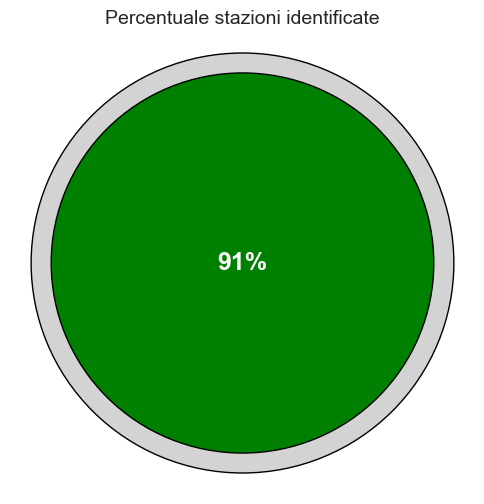

In [17]:
# Partiamo dal dataframe già caricato in memoria: df_station
df = df_station.copy()

# Trova le stazioni con la regione valorizzata
df["has_region"] = df["region"].notna() & (df["region"].str.strip() != "")
df["complete_info"] = df["has_region"]

# Definisci "Identificate" quelle con valori true e "Non identificate" quelle con valori false
summary = df["complete_info"].value_counts().rename(index={True: "Identificate", False: "Non identificate"}).reset_index()

# Imposta l'asse x con "Status" e l'asse y con "Count"
summary.columns = ["Status", "Count"]

# Dati dal dataframe 'summary'
identificate = summary.loc[summary["Status"] == "Identificate", "Count"].values[0]
non_identificate = summary.loc[summary["Status"] == "Non identificate", "Count"].values[0]
totale = identificate + non_identificate

# Percentuale identificate
perc_identificate = identificate / totale

# Crea la figura
fig, ax = plt.subplots(figsize=(6, 6))

# Cerchio esterno – totale (vuoto)
outer_circle = plt.Circle((0, 0), 1, color='lightgray', ec='black')

# Cerchio interno – proporzione identificate
inner_circle = plt.Circle((0, 0), perc_identificate, color='green', ec='black')

# Aggiunge i cerchi
ax.add_artist(outer_circle)
ax.add_artist(inner_circle)

# Testo al centro
ax.text(0, 0, f'{perc_identificate:.0%}', va='center', ha='center', fontsize=18, fontweight='bold', color='white')

# Rimuovi assi
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.axis('off')

# Titolo
plt.title("Percentuale stazioni identificate", fontsize=14)

# Mostra il grafico
plt.show()


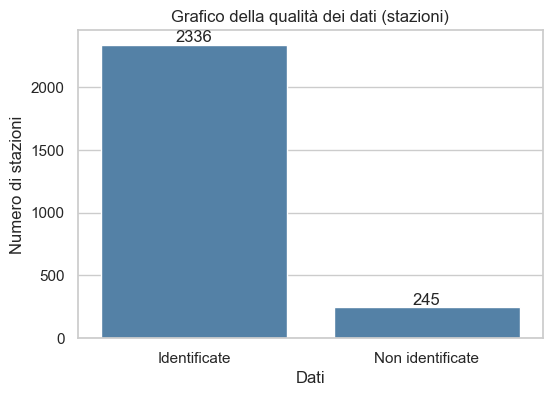

In [53]:
# Usa df_station già caricato
df = df_station.copy()

# Trova le stazioni con la regione valorizzata
df["has_region"] = df["region"].notna() & (df["region"].str.strip() != "")
df["complete_info"] = df["has_region"]

# Definisci "Identificate" quelle con valori true e "Non identificate" quelle con valori false
summary = df["complete_info"].value_counts().rename(index={True: "Identificate", False: "Non identificate"}).reset_index()

# Rinomina colonne
summary.columns = ["Status", "Count"]

# Imposta il tema
sns.set(style="whitegrid")

# Crea figura
plt.figure(figsize=(6, 4))

# Barplot con colori personalizzati
ax = sns.barplot(
    x="Status", 
    y="Count", 
    data=summary, 
    hue="Status",
    palette={"Identificate": "steelblue", "Non identificate": "steelblue"}, 
    legend=False
)

# Titoli assi e grafico
ax.set_title("Grafico della qualità dei dati (stazioni)")
ax.set_ylabel("Numero di stazioni")
ax.set_xlabel("Dati")

# Aggiungi etichette sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Mostra il grafico
plt.show()

<h3>Distrubuzione delle stazioni su base regionale</h3>

<h3>Distrubuzione stazioni nel territorio italiano</h3>

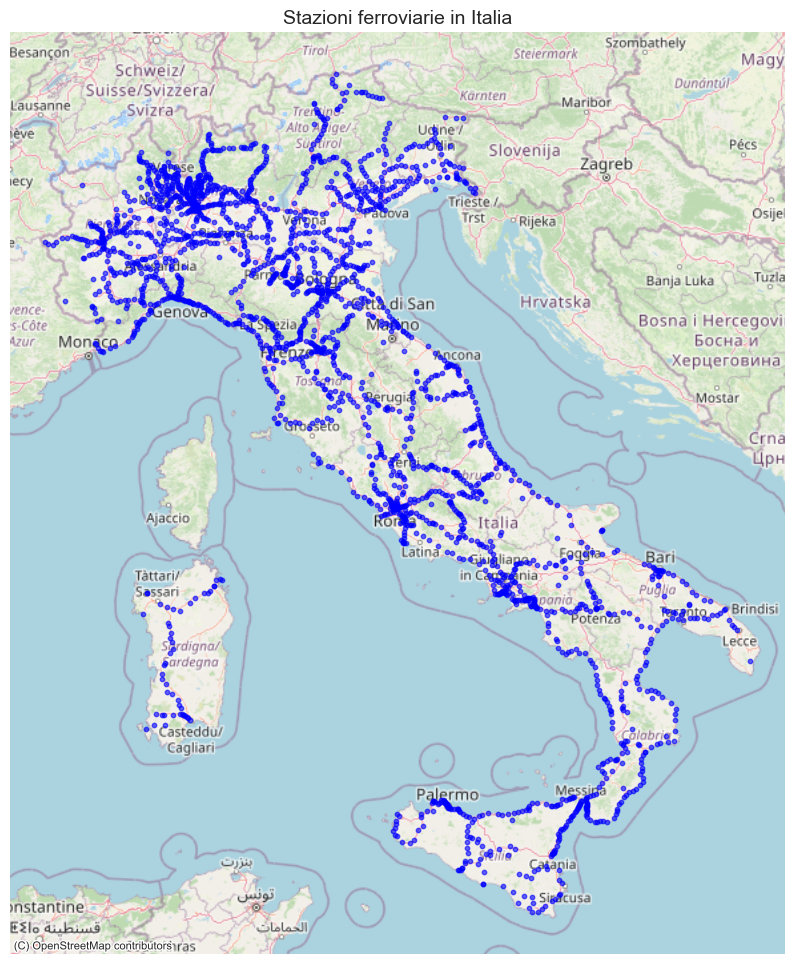

In [19]:
# Filtra solo le stazioni con coordinate valide
df = df_station[df_station["latitude"].notna() & df_station["longitude"].notna()].copy()

# Crea GeoDataFrame con coordinate geografiche (EPSG:4326)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# Proietta in EPSG:3857 (Web Mercator) per contextily
gdf = gdf.to_crs(epsg=3857)

# Crea mappa
fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(ax=ax, markersize=10, color="blue", alpha=0.6)

# Aggiungi sfondo da OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

# Titolo
plt.title("Stazioni ferroviarie in Italia", fontsize=14)
plt.show()

<h3>Ritardo medio arrivo per regione</h3>

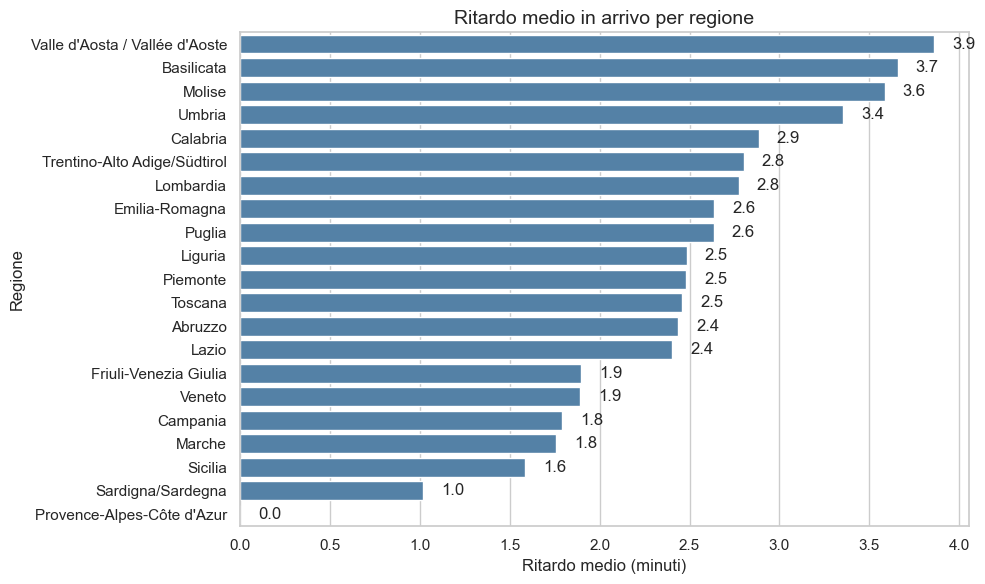

In [22]:
# Unisci df_timetable e df_station sulla chiave station_id = id
df = df_timetable.merge(
    df_station[["id", "region"]],
    left_on="station_id",
    right_on="id",
    how="left"
)

# Filtro: solo righe con regione valida
df = df[
    (df["region"].notna()) &
    (df["region"].str.strip() != "")
].copy()

# Sostituisci NaN nei ritardi con 0 (come COALESCE in SQL)
df["arrival_delay"] = df["arrival_delay"].fillna(0)

# Calcola ritardo medio per regione
df_avg_region = df.groupby("region")["arrival_delay"].mean().reset_index()

# Ordina per ritardo decrescente
df_avg_region = df_avg_region.sort_values(by="arrival_delay", ascending=False)

# Stile
sns.set(style="whitegrid")

# Grafico
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_avg_region,
    y="region",
    x="arrival_delay",
    color="steelblue"
)

# Titoli e label
ax.set_title("Ritardo medio in arrivo per regione", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Regione")

# Etichette sulle barre
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/2,
            f"{i.get_width():.1f}", va='center')

# Ottimizza layout
plt.tight_layout()
plt.show()

<h3>Ritardo medio partenze per regione</h3>

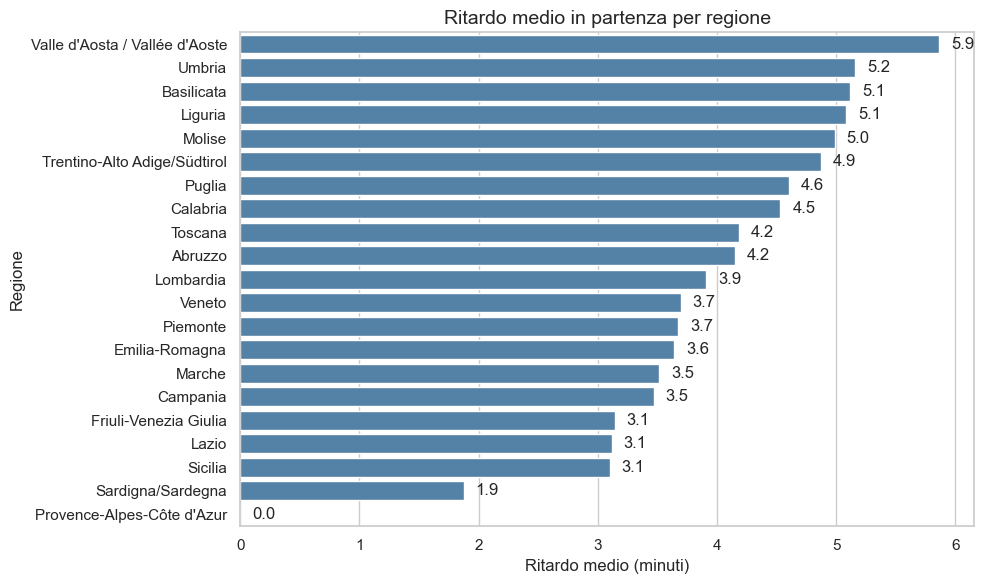

In [29]:
# Unione tra df_timetable e df_station per aggiungere la regione
df = df_timetable.merge(
    df_station[["id", "region"]],
    left_on="station_id",
    right_on="id",
    how="left"
)

# Filtro: solo righe con regione valida
df = df[
    (df["region"].notna()) &
    (df["region"].str.strip() != "")
].copy()

# Sostituisci NaN nei ritardi di partenza con 0 (equivalente a COALESCE)
df["departure_delay"] = df["departure_delay"].fillna(0)

# Calcola ritardo medio per regione
df_avg_region = df.groupby("region")["departure_delay"].mean().reset_index()

# Ordina in modo decrescente
df_avg_region = df_avg_region.sort_values(by="departure_delay", ascending=False)

# Stile del grafico
sns.set(style="whitegrid")

# Crea figura
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_avg_region,
    y="region",
    x="departure_delay",
    color="steelblue"
)

# Titoli e etichette
ax.set_title("Ritardo medio in partenza per regione", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Regione")

# Etichette numeriche sulle barre
for bar in ax.patches:
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.1f}", va="center")

# Ottimizza layout
plt.tight_layout()
plt.show()

<h3>Giornate con più cancellazioni</h3>

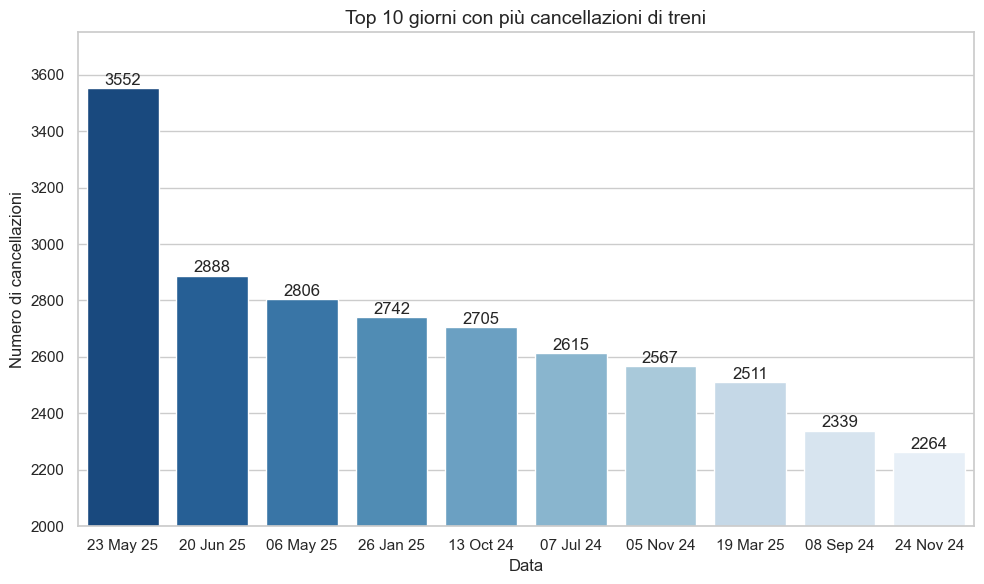

In [34]:
# Filtra treni cancellati dal df_timetable
df = df_timetable[df_timetable["deleted"] == True].copy()

# Conta cancellazioni per giorno
df_delete_count_byday = df.groupby("day_number")["train_id"].count().reset_index()
df_delete_count_byday = df_delete_count_byday.rename(columns={"train_id": "cancellations"})

# Calcola la data a partire dal day_number
base_date = pd.to_datetime("2024-07-01")
df_delete_count_byday["date"] = base_date + pd.to_timedelta(df_delete_count_byday["day_number"], unit="D")

# Prende i top 10 giorni con più cancellazioni
df_top10 = df_delete_count_byday.sort_values(by="cancellations", ascending=False).head(10)

# Formatta la data per l'asse x
df_top10["date_str"] = df_top10["date"].dt.strftime("%d %b %y")

# Palette e ordinamento per il grafico
palette = sns.color_palette("Blues", n_colors=len(df_top10))[::-1]
df_top10 = df_top10.sort_values(by="cancellations", ascending=False)

# Crea il grafico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_top10,
    x="date_str",
    y="cancellations",
    hue="date_str",
    palette=palette,
    dodge=False
)

# Titoli e assi
ax.set_title("Top 10 giorni con più cancellazioni di treni", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Numero di cancellazioni")
ax.set_ylim([2000, 3750]);

# Etichette sopra le barre
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f"{int(bar.get_height())}",
            ha="center", va="bottom")

# Ottimizza layout
plt.tight_layout()
plt.show()

<h3>Giornate con ritardi maggiori</h3>

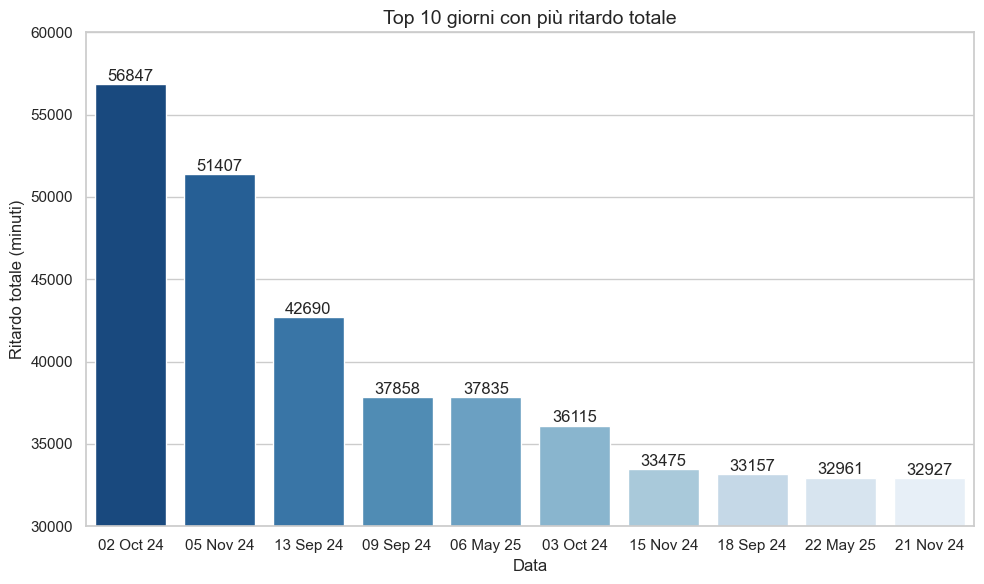

In [25]:
# Data di riferimento
base_date = pd.to_datetime("2024-07-01")

# Filtra solo fermate valide (non cancellate)
df = df_timetable[
    (df_timetable["deleted"] == False)
].copy()

# Trova la fermata finale per ciascun treno ogni giorno
df_last_stops = df.sort_values("stop_number").groupby(["day_number", "train_id"]).tail(1)

# Calcola il ritardo totale per giorno
df_delay_by_day = df_last_stops.groupby("day_number")["arrival_delay"].sum().reset_index()
df_delay_by_day = df_delay_by_day.rename(columns={"arrival_delay": "total_arrival_delay"})

# Aggiungi la colonna con data reale
df_delay_by_day["date"] = base_date + pd.to_timedelta(df_delay_by_day["day_number"], unit="D")

# Prendi i 10 giorni con più ritardo totale
df_top10_delay = df_delay_by_day.sort_values(by="total_arrival_delay", ascending=False).head(10)

# Aggiungi colonna formattata per asse X
df_top10_delay["date_str"] = df_top10_delay["date"].dt.strftime("%d %b %y")

# Palette rossa invertita
palette = sns.color_palette("Blues", n_colors=len(df_top10_delay))[::-1]

# Ordina per ritardo decrescente (per applicare i colori correttamente)
df_top10_delay = df_top10_delay.sort_values(by="total_arrival_delay", ascending=False)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_top10_delay,
    x="date_str",
    y="total_arrival_delay",
    hue="date_str",
    palette=palette,
    dodge=False
)

# Titoli e assi
ax.set_title("Top 10 giorni con più ritardo totale", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Ritardo totale (minuti)")
ax.set_ylim([30000,60000]);

# Etichette sopra le barre
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 5,
            f"{int(bar.get_height())}",
            ha="center", va="bottom")

# Ottimizza layout
plt.tight_layout()
plt.show()

<h3>Trend andamento ritardo nel tempo</h3>

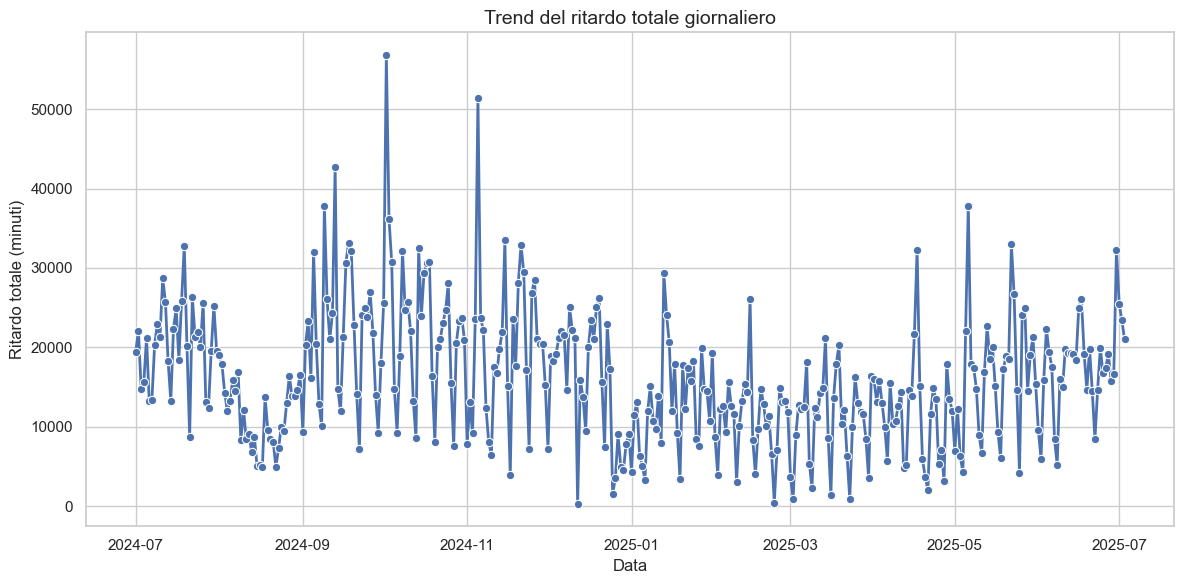

In [22]:
# Data di riferimento
base_date = pd.to_datetime("2024-07-01")

# Filtra solo le righe valide
df = df_timetable[
    (df_timetable["deleted"] == False)
].copy()

# Trova la fermata finale (stop_number massimo per train_id e day_number)
df_last_stops = df.sort_values("stop_number").groupby(["day_number", "train_id"]).tail(1)

# Calcola il ritardo totale per ogni giorno
df_delay_by_day = df_last_stops.groupby("day_number")["arrival_delay"].sum().reset_index()
df_delay_by_day = df_delay_by_day.rename(columns={"arrival_delay": "total_arrival_delay"})

# Aggiungi la colonna con data effettiva
df_delay_by_day["date"] = base_date + pd.to_timedelta(df_delay_by_day["day_number"], unit="D")

# Ordina per data (fondamentale per grafico a linee)
df_delay_by_day = df_delay_by_day.sort_values("date")

# Crea il grafico a linee
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_delay_by_day,
    x="date",
    y="total_arrival_delay",
    marker="o",
    linewidth=2,
    color="b"
)

# Titoli e label assi
ax.set_title("Trend del ritardo totale giornaliero", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Ritardo totale (minuti)")

# Ottimizza layout
plt.tight_layout()
plt.show()

<h3>Tratte con maggior ritardo medio</h3>

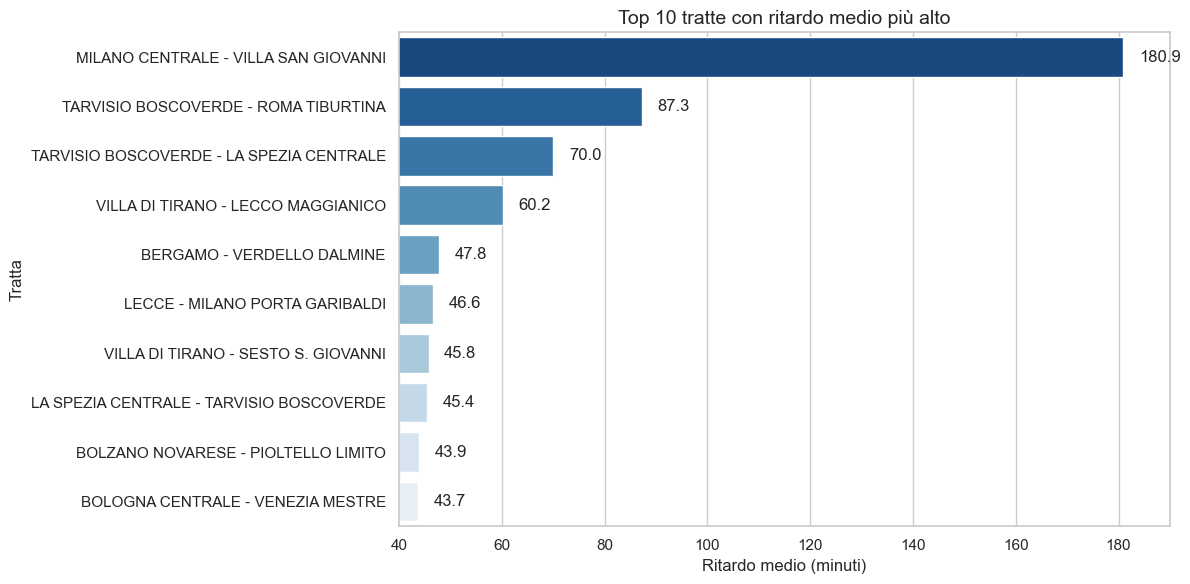

In [50]:
# Unisci timetable + station per avere gli alias
df = df_timetable.merge(
    df_station[["id", "alias"]],
    left_on="station_id",
    right_on="id",
    how="left"
)

# Pulisci alias: prendi il primo valore del JSON array
df["alias_clean"] = df["alias"].apply(lambda x: json.loads(x)[0] if pd.notna(x) else None)

# Filtra solo righe valide
df = df[
    (df["deleted"] == False)
].copy()

# Prima e ultima fermata per ogni treno e giorno
df_first = df.sort_values("stop_number").groupby(["day_number", "train_id"]).first().reset_index()
df_last  = df.sort_values("stop_number").groupby(["day_number", "train_id"]).last().reset_index()

# Crea tratta: alias partenza + alias arrivo
df_route = pd.merge(
    df_first[["day_number", "train_id", "alias_clean"]],
    df_last[["day_number", "train_id", "alias_clean", "arrival_delay"]],
    on=["day_number", "train_id"],
    suffixes=("_from", "_to")
)
df_route["route"] = df_route["alias_clean_from"] + " - " + df_route["alias_clean_to"]

# Statistiche per tratta
df_stats_by_route = df_route.groupby("route").agg(
    avg_arrival_delay=("arrival_delay", "mean"),
    num_trips=("arrival_delay", "count")
).reset_index()

df_stats_by_route = df_stats_by_route[df_stats_by_route["num_trips"] >= 10]

# Top 10 tratte per ritardo medio
df_top10_routes = df_stats_by_route.sort_values("avg_arrival_delay", ascending=False).head(10)

# Grafico
palette = sns.color_palette("Blues", n_colors=len(df_top10_routes))[::-1]

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=df_top10_routes,
    x="avg_arrival_delay",
    y="route",
    hue="route",
    palette=palette,
    dodge=False
)

# Titoli e etichette
ax.set_title("Top 10 tratte con ritardo medio più alto", fontsize=14)
ax.set_xlabel("Ritardo medio (minuti)")
ax.set_ylabel("Tratta")
ax.set_xlim([40,190]);

# Valori accanto alle barre
for bar in ax.patches:
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.1f}", va="center")

# Ottimizza layout
plt.tight_layout()
plt.show()

Pearson:  0.193
Spearman: 0.191
Kendall:  0.129


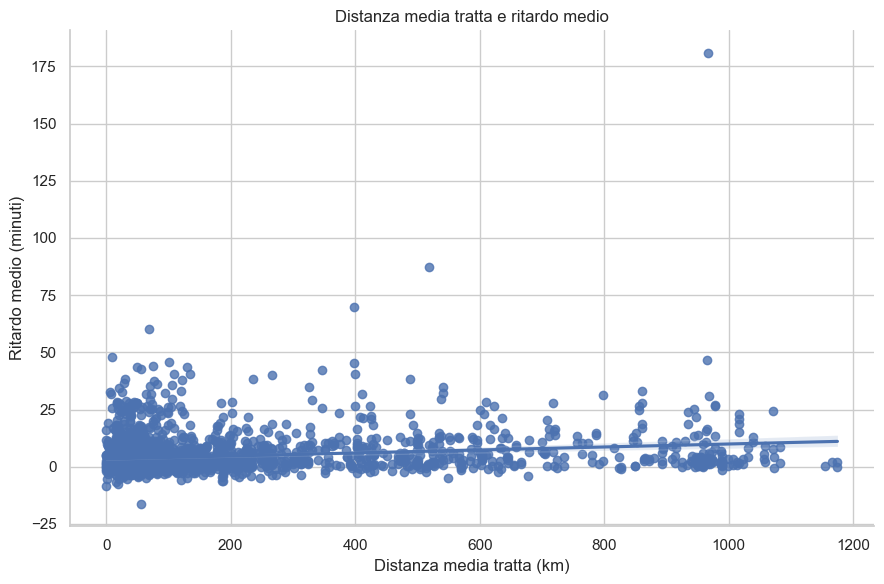

In [96]:
# Filtro fermate valide (non cancellate e con lat/lon)
df = df_timetable.merge(
    df_station[["id", "alias", "latitude", "longitude"]],
    left_on="station_id",
    right_on="id",
    how="left"
)

df = df[
    (df["deleted"] == False) &
    (df["latitude"].notna()) &
    (df["longitude"].notna())
].copy()

# Estrai primo alias dal campo JSON
df["alias_clean"] = df["alias"].apply(lambda x: json.loads(x)[0] if pd.notna(x) else None)

# Ordina per posizione nella tratta
df_sorted = df.sort_values("stop_number")

# Estrai la prima e l’ultima fermata per ogni treno
df_first = df_sorted.groupby(["day_number", "train_id"]).first().reset_index()
df_last  = df_sorted.groupby(["day_number", "train_id"]).last().reset_index()

# Prima stazione
df_first = df_first.rename(columns={
    "alias_clean": "alias_clean_from",
    "latitude": "lat_from",
    "longitude": "lon_from"
})

# Ultima stazione
df_last = df_last.rename(columns={
    "alias_clean": "alias_clean_to",
    "latitude": "lat_to",
    "longitude": "lon_to"
})

# Merge per ottenere dati tratta
df_route = pd.merge(
    df_first[["day_number", "train_id", "alias_clean_from", "lat_from", "lon_from"]],
    df_last[["day_number", "train_id", "alias_clean_to", "lat_to", "lon_to", "arrival_delay"]],
    on=["day_number", "train_id"]
)

# Calcola distanza in km con haversine
df_route["distance_km"] = df_route.apply(lambda row: haversine(
    (row["lat_from"], row["lon_from"]), (row["lat_to"], row["lon_to"])
), axis=1)

# Crea nome tratta
df_route["route"] = df_route["alias_clean_from"] + " - " + df_route["alias_clean_to"]

# Calcola media ritardo/distanza per tratta
df_stats_by_route = df_route.groupby("route").agg(
    avg_arrival_delay=("arrival_delay", "mean"),
    avg_distance_km=("distance_km", "mean"),
    num_trips=("arrival_delay", "count")
).reset_index()

# Filtra tratte percorse almeno 10 volte (opzionale)
df_stats_by_route = df_stats_by_route[df_stats_by_route["num_trips"] >= 10]

# Calcolo delle correlazioni
pearson_corr = df_stats_by_route['avg_distance_km'].corr(df_stats_by_route['avg_arrival_delay'], method='pearson')
spearman_corr = df_stats_by_route['avg_distance_km'].corr(df_stats_by_route['avg_arrival_delay'], method='spearman')
kendall_corr = df_stats_by_route['avg_distance_km'].corr(df_stats_by_route['avg_arrival_delay'], method='kendall')

print(f"Pearson:  {pearson_corr:.3f}")
print(f"Spearman: {spearman_corr:.3f}")
print(f"Kendall:  {kendall_corr:.3f}")

# Plot
sns.set(style="whitegrid")

sns.lmplot(
    data=df_stats_by_route,
    x="avg_distance_km",
    y="avg_arrival_delay",
    height=6,
    aspect=1.5
)

plt.title("Distanza media tratta e ritardo medio")
plt.xlabel("Distanza media tratta (km)")
plt.ylabel("Ritardo medio (minuti)")
plt.tight_layout()
plt.show()

In [39]:
# Clustering con KMeans (3 cluster)

# Aggregazione caratteristiche per stazione
df_features = df_timetable.groupby('station_id').agg({
    'arrival_delay': 'mean',
    'departure_delay': 'mean',
    'train_id': 'count',
    'deleted': 'mean'
}).rename(columns={'train_id': 'num_trains'}).reset_index()

# Merge con info stazioni
df_merged = pd.merge(df_features, df_station, left_on='station_id', right_on='id')
df_merged = df_merged[df_merged['latitude'].notnull() & df_merged['longitude'].notnull()]
df_merged = df_merged[df_merged['num_trains'] > 10]

# Selezione feature per clustering
X = df_merged[['arrival_delay', 'departure_delay']]

# Imputazione valori NaN
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Clustering con KMeans a 5 cluster
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_3.fit_predict(X_scaled)
df_merged['cluster'] = clusters

# Centroidi nel formato originale (non scalato)
centroids_scaled = kmeans_3.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

# Definisci le etichette con centroidi e una valutazione qualitativa
# Ordina i cluster per ritardo medio di arrivo + partenza (somma centroidi)
centroid_sums = centroids.sum(axis=1)
order = centroid_sums.argsort()

labels_ordered = ['Cluster 1', 'Cluster 2', 'Cluster 3']

cluster_labels = {}
for pos, cluster_idx in enumerate(order):
    centroid = centroids[cluster_idx]
    label = f"{labels_ordered[pos]} (Arr: {centroid[0]:.1f}, Part: {centroid[1]:.1f})"
    cluster_labels[cluster_idx] = label

df_merged['cluster_label'] = df_merged['cluster'].map(cluster_labels)

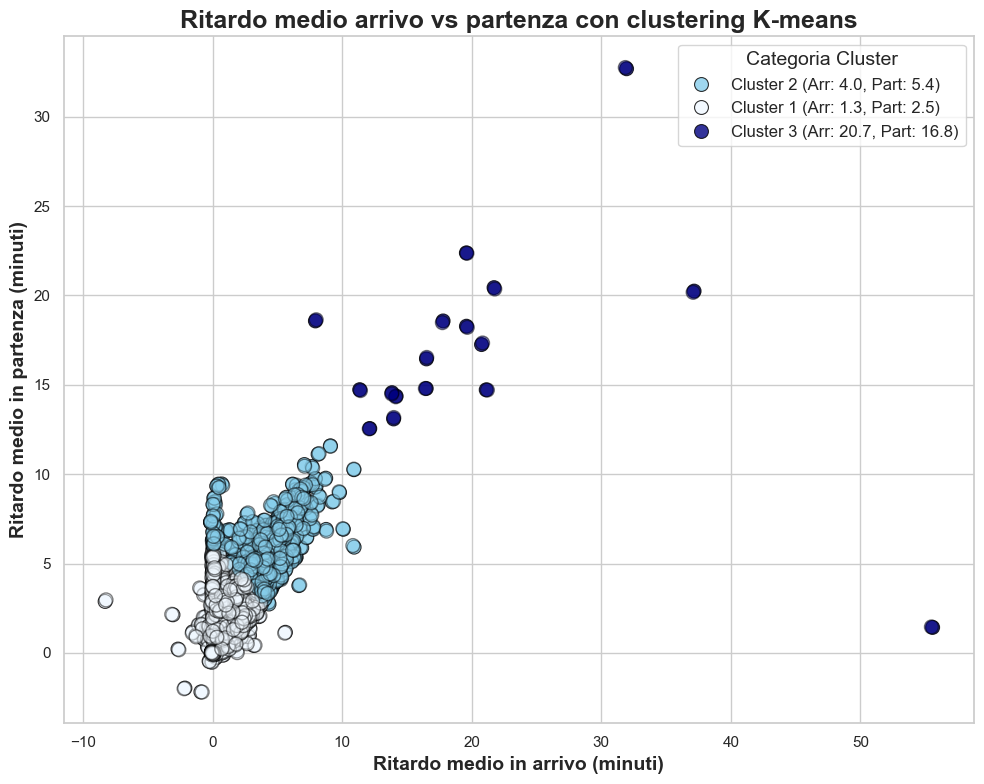

In [59]:
# Scatterplot ritardi con colori cluster

color_map = {
    cluster_labels[k]: c for k, c in zip(range(3), ['aliceblue', 'skyblue', 'navy'])
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_merged,
    x='arrival_delay',
    y='departure_delay',
    hue='cluster_label',
    palette=color_map,
    s=100,
    edgecolor='black',
    alpha=0.8
)

plt.title('Ritardo medio arrivo vs partenza con clustering K-means', fontsize=18, fontweight='bold')
plt.xlabel('Ritardo medio in arrivo (minuti)', fontsize=14, fontweight='bold')
plt.ylabel('Ritardo medio in partenza (minuti)', fontsize=14, fontweight='bold')

# Jitter per evitare sovrapposizione
jitter = 0.1
x_jittered = df_merged['arrival_delay'] + np.random.uniform(-jitter, jitter, size=len(df_merged))
y_jittered = df_merged['departure_delay'] + np.random.uniform(-jitter, jitter, size=len(df_merged))
plt.scatter(
    x_jittered,
    y_jittered,
    c=[color_map[c] for c in df_merged['cluster_label']],
    s=100,
    edgecolor='black',
    alpha=0.5
)

plt.legend(title='Categoria Cluster', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

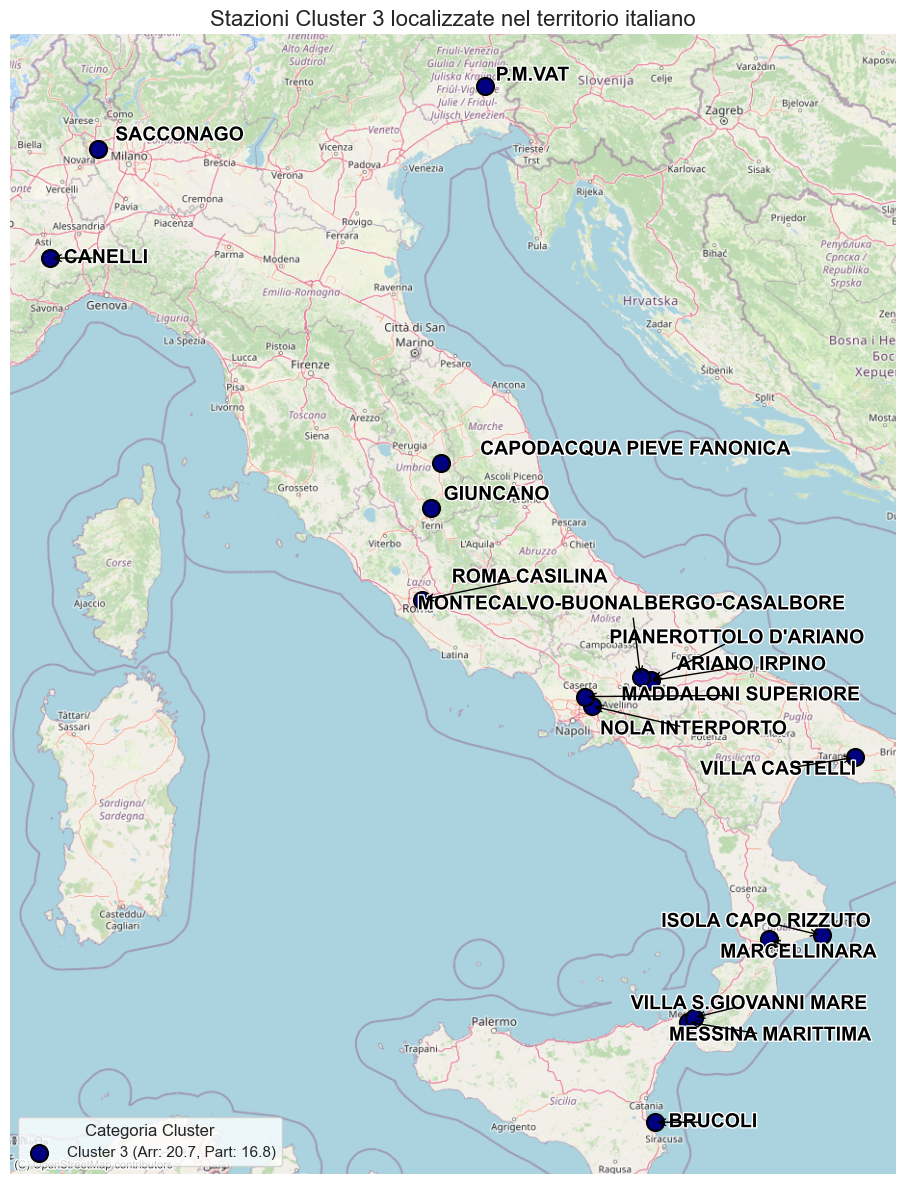

In [60]:
# Mappa OpenStreetMap

# Crea GeoDataFrame con coordinate e CRS corretto
gdf = gpd.GeoDataFrame(
    df_merged,
    geometry=gpd.points_from_xy(df_merged.longitude, df_merged.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Filtra solo cluster Critico
critico_label = [label for label in cluster_labels.values() if "Cluster 3" in label][0]

gdf_filtered = gdf[gdf['cluster_label'].isin([critico_label])]

fig, ax = plt.subplots(figsize=(14, 12))

for label, color in color_map.items():
    if label in [critico_label]:
        subset = gdf_filtered[gdf_filtered['cluster_label'] == label]
        size = 150
        lw = 1.5
        subset.plot(
            ax=ax,
            color=color,
            markersize=size,
            edgecolor='black',
            linewidth=lw,
            label=label
        )

# Aggiungi nomi stazioni (primo elemento JSON in alias)
texts = []
for idx, row in gdf_filtered.iterrows():
    try:
        alias_list = json.loads(row['alias'])
        station_name = alias_list[0] if isinstance(alias_list, list) and len(alias_list) > 0 else row['alias']
    except Exception:
        station_name = row['alias']
    
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            station_name,
            fontsize=14,
            fontweight='bold',
            color='black',
            path_effects=[patheffects.withStroke(linewidth=2, foreground="white")]
        )
    )

adjust_text(
    texts, ax=ax, 
    expand_points=(2, 2), 
    arrowprops=dict(arrowstyle='->', color='black', shrinkA=10)
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Stazioni Cluster 3 localizzate nel territorio italiano", fontsize=16)
ax.set_axis_off()
plt.legend(title='Categoria Cluster', loc='lower left')

plt.tight_layout()
plt.show()